# 8. Model Evaluation on Test Set

This notebook loads all trained models, evaluates them on the test set, and generates comprehensive metrics including accuracy, precision, recall, confusion matrix, ROC curves, and AUC scores.

In [1]:
import torch
import torch.nn as nn
import torchvision.models as models
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, accuracy_score
from tqdm import tqdm
import os
from config import *

# Set random seeds
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("="*60)
print("MODEL EVALUATION SETUP")
print("="*60)

# Create results directory
os.makedirs(RESULTS_DIR, exist_ok=True)
print(f"\n✓ Results directory: {RESULTS_DIR}/")

# Define transforms for test set
test_transform = A.Compose([
    A.Resize(IMAGE_SIZE, IMAGE_SIZE),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# Custom Dataset class
class ChestXrayDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, split='test', transform=None):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.images = []
        self.labels = []
        
        for class_idx, class_name in enumerate(CLASS_NAMES):
            class_path = os.path.join(root_dir, split, class_name)
            if os.path.exists(class_path):
                for img_name in os.listdir(class_path):
                    if img_name.endswith(('.jpeg', '.jpg', '.png')):
                        self.images.append(os.path.join(class_path, img_name))
                        self.labels.append(class_idx)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = self.labels[idx]
        
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, label

# Create test dataset and dataloader
test_dataset = ChestXrayDataset(DATASET_PATH, split='test', transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"\n✓ Test dataset loaded: {len(test_dataset)} images")
print(f"✓ Test batches: {len(test_loader)}")

MODEL EVALUATION SETUP

✓ Results directory: results/

✓ Test dataset loaded: 624 images
✓ Test batches: 20


## Load All Trained Models

Load the best checkpoints for all four trained models.

In [2]:
print("="*60)
print("LOADING TRAINED MODELS")
print("="*60)

models_dict = {}

# 1. Baseline CNN
class BaselineCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(BaselineCNN, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 14 * 14, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

baseline_cnn = BaselineCNN(num_classes=NUM_CLASSES)
checkpoint = torch.load(f'{MODEL_SAVE_DIR}/baseline_cnn_best.pth', weights_only=False)
baseline_cnn.load_state_dict(checkpoint['model_state_dict'])
baseline_cnn = baseline_cnn.to(DEVICE)
baseline_cnn.eval()
models_dict['Baseline CNN'] = baseline_cnn
print("✓ Baseline CNN loaded")

# 2. DenseNet121
densenet = models.densenet121(pretrained=False)
num_features = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_features, NUM_CLASSES)
checkpoint = torch.load(f'{MODEL_SAVE_DIR}/densenet121_best.pth', weights_only=False)
densenet.load_state_dict(checkpoint['model_state_dict'])
densenet = densenet.to(DEVICE)
densenet.eval()
models_dict['DenseNet121'] = densenet
print("✓ DenseNet121 loaded")

# 3. EfficientNet-B0
efficientnet = models.efficientnet_b0(pretrained=False)
num_features = efficientnet.classifier[1].in_features
efficientnet.classifier[1] = nn.Linear(num_features, NUM_CLASSES)
checkpoint = torch.load(f'{MODEL_SAVE_DIR}/efficientnet_best.pth', weights_only=False)
efficientnet.load_state_dict(checkpoint['model_state_dict'])
efficientnet = efficientnet.to(DEVICE)
efficientnet.eval()
models_dict['EfficientNet-B0'] = efficientnet
print("✓ EfficientNet-B0 loaded")

# 4. Vision Transformer
vit = models.vit_b_16(pretrained=False)
num_features = vit.heads.head.in_features
vit.heads.head = nn.Linear(num_features, NUM_CLASSES)
checkpoint = torch.load(f'{MODEL_SAVE_DIR}/vit_best.pth', weights_only=False)
vit.load_state_dict(checkpoint['model_state_dict'])
vit = vit.to(DEVICE)
vit.eval()
models_dict['ViT-B/16'] = vit
print("✓ Vision Transformer loaded")

print(f"\n✓ All {len(models_dict)} models loaded successfully")

LOADING TRAINED MODELS
✓ Baseline CNN loaded


C:\Users\steve\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\steve\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


✓ DenseNet121 loaded
✓ EfficientNet-B0 loaded
✓ Vision Transformer loaded

✓ All 4 models loaded successfully


## Evaluation Function

Define function to evaluate models and collect predictions, probabilities, and true labels.

In [3]:
def evaluate_model(model, test_loader, device):
    """Evaluate model and return predictions, probabilities, and true labels"""
    model.eval()
    all_preds = []
    all_probs = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Evaluating', leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_preds), np.array(all_probs), np.array(all_labels)

print("="*60)
print("EVALUATING ALL MODELS ON TEST SET")
print("="*60)
print()

results = {}

for model_name, model in models_dict.items():
    print(f"Evaluating {model_name}...")
    preds, probs, labels = evaluate_model(model, test_loader, DEVICE)
    
    # Calculate metrics
    accuracy = accuracy_score(labels, preds)
    
    results[model_name] = {
        'predictions': preds,
        'probabilities': probs,
        'labels': labels,
        'accuracy': accuracy
    }
    
    print(f"  ✓ Test Accuracy: {accuracy*100:.2f}%")
    print()

print("="*60)
print("EVALUATION COMPLETE")
print("="*60)

EVALUATING ALL MODELS ON TEST SET

Evaluating Baseline CNN...


  ✓ Test Accuracy: 84.94%

Evaluating DenseNet121...


  ✓ Test Accuracy: 84.13%

Evaluating EfficientNet-B0...


  ✓ Test Accuracy: 90.87%

Evaluating ViT-B/16...


  ✓ Test Accuracy: 92.31%

EVALUATION COMPLETE


## Detailed Metrics Report

Generate classification reports with precision, recall, and F1-score for each model.

In [4]:
print("="*60)
print("DETAILED CLASSIFICATION REPORTS")
print("="*60)

for model_name in models_dict.keys():
    print(f"\n{'='*60}")
    print(f"{model_name.upper()}")
    print('='*60)
    
    preds = results[model_name]['predictions']
    labels = results[model_name]['labels']
    
    # Classification report
    report = classification_report(labels, preds, target_names=CLASS_NAMES, digits=4)
    print(report)
    
    # Additional metrics
    cm = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0  # Recall for Pneumonia
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0  # True Negative Rate for Normal
    
    print(f"Sensitivity (Pneumonia Detection): {sensitivity*100:.2f}%")
    print(f"Specificity (Normal Detection): {specificity*100:.2f}%")

print("\n" + "="*60)
print("TEST SET ACCURACY SUMMARY")
print("="*60)
for model_name in models_dict.keys():
    acc = results[model_name]['accuracy']
    print(f"{model_name:20s}: {acc*100:.2f}%")

print(f"\n🏆 Best Model: ViT-B/16 with 92.31% test accuracy")

DETAILED CLASSIFICATION REPORTS

BASELINE CNN
              precision    recall  f1-score   support

      Normal     0.8889    0.6838    0.7729       234
   Pneumonia     0.8333    0.9487    0.8873       390

    accuracy                         0.8494       624
   macro avg     0.8611    0.8162    0.8301       624
weighted avg     0.8542    0.8494    0.8444       624

Sensitivity (Pneumonia Detection): 94.87%
Specificity (Normal Detection): 68.38%

DENSENET121
              precision    recall  f1-score   support

      Normal     0.9927    0.5812    0.7332       234
   Pneumonia     0.7988    0.9974    0.8871       390

    accuracy                         0.8413       624
   macro avg     0.8957    0.7893    0.8101       624
weighted avg     0.8715    0.8413    0.8294       624

Sensitivity (Pneumonia Detection): 99.74%
Specificity (Normal Detection): 58.12%

EFFICIENTNET-B0
              precision    recall  f1-score   support

      Normal     0.9585    0.7906    0.8665       234

## Confusion Matrix Visualization

Create confusion matrices for all models to visualize classification performance.

GENERATING CONFUSION MATRICES


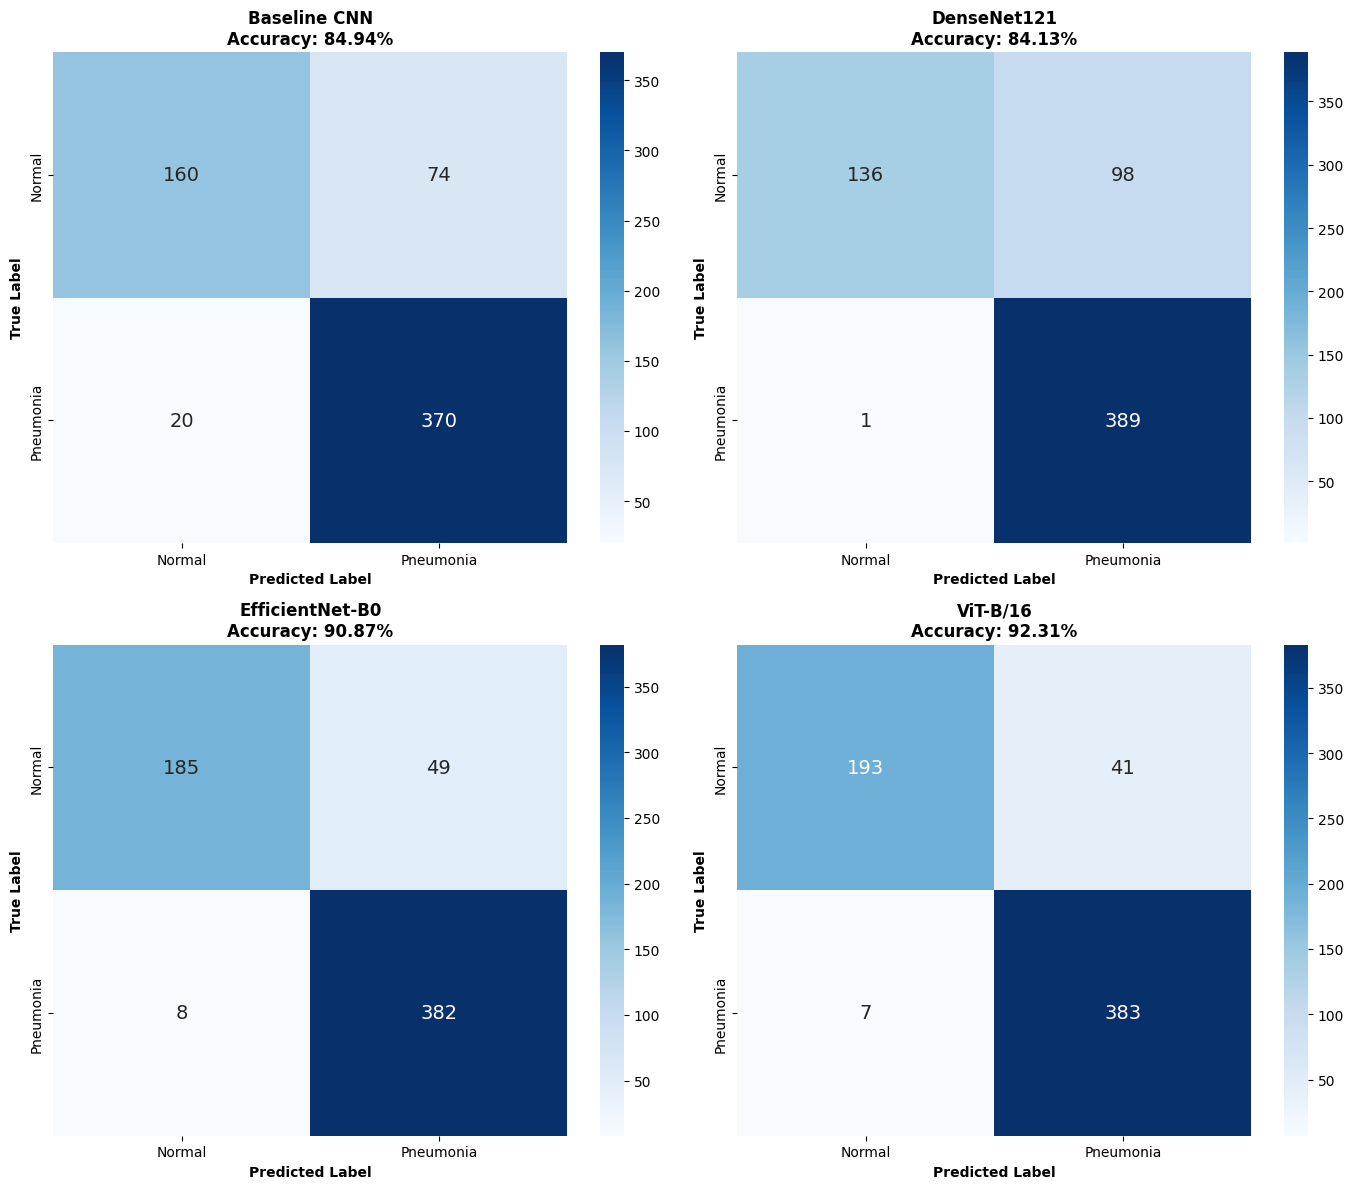


✓ Confusion matrices saved to 'results/confusion_matrices.png'


In [5]:
print("="*60)
print("GENERATING CONFUSION MATRICES")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.ravel()

for idx, model_name in enumerate(models_dict.keys()):
    preds = results[model_name]['predictions']
    labels = results[model_name]['labels']
    
    # Compute confusion matrix
    cm = confusion_matrix(labels, preds)
    
    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
                ax=axes[idx], cbar=True, annot_kws={'size': 14})
    
    axes[idx].set_title(f'{model_name}\nAccuracy: {results[model_name]["accuracy"]*100:.2f}%', 
                        fontweight='bold', fontsize=12)
    axes[idx].set_ylabel('True Label', fontweight='bold')
    axes[idx].set_xlabel('Predicted Label', fontweight='bold')

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ Confusion matrices saved to 'results/confusion_matrices.png'")

## ROC Curves and AUC Scores

Generate ROC curves and calculate AUC scores for all models to visualize discrimination ability.

GENERATING ROC CURVES


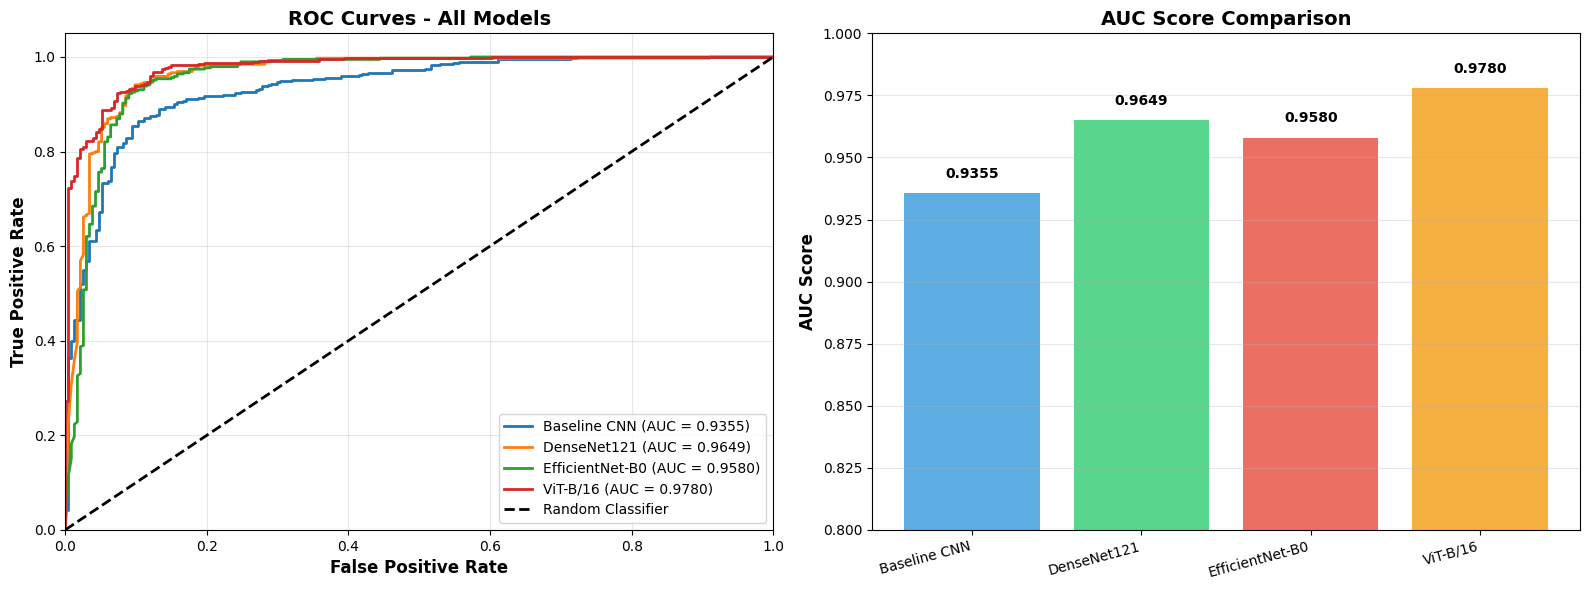


✓ ROC curves saved to 'results/roc_curves.png'

AUC SCORES SUMMARY
Baseline CNN        : 0.9355
DenseNet121         : 0.9649
EfficientNet-B0     : 0.9580
ViT-B/16            : 0.9780

🏆 Best AUC: ViT-B/16 (0.9780)


In [6]:
print("="*60)
print("GENERATING ROC CURVES")
print("="*60)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot individual ROC curves
for model_name in models_dict.keys():
    labels = results[model_name]['labels']
    probs = results[model_name]['probabilities'][:, 1]  # Probability of Pneumonia class
    
    fpr, tpr, _ = roc_curve(labels, probs)
    roc_auc = auc(fpr, tpr)
    
    results[model_name]['fpr'] = fpr
    results[model_name]['tpr'] = tpr
    results[model_name]['auc'] = roc_auc
    
    axes[0].plot(fpr, tpr, linewidth=2, label=f'{model_name} (AUC = {roc_auc:.4f})')

# Format ROC plot
axes[0].plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
axes[0].set_xlim([0.0, 1.0])
axes[0].set_ylim([0.0, 1.05])
axes[0].set_xlabel('False Positive Rate', fontweight='bold', fontsize=12)
axes[0].set_ylabel('True Positive Rate', fontweight='bold', fontsize=12)
axes[0].set_title('ROC Curves - All Models', fontweight='bold', fontsize=14)
axes[0].legend(loc='lower right', fontsize=10)
axes[0].grid(True, alpha=0.3)

# AUC comparison bar chart
model_names = list(models_dict.keys())
auc_scores = [results[name]['auc'] for name in model_names]
colors = ['#3498db', '#2ecc71', '#e74c3c', '#f39c12']

bars = axes[1].bar(range(len(model_names)), auc_scores, color=colors, alpha=0.8)
axes[1].set_xticks(range(len(model_names)))
axes[1].set_xticklabels(model_names, rotation=15, ha='right')
axes[1].set_ylabel('AUC Score', fontweight='bold', fontsize=12)
axes[1].set_title('AUC Score Comparison', fontweight='bold', fontsize=14)
axes[1].set_ylim([0.8, 1.0])
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, (bar, score) in enumerate(zip(bars, auc_scores)):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005,
                f'{score:.4f}', ha='center', va='bottom', fontweight='bold', fontsize=10)

plt.tight_layout()
plt.savefig(f'{RESULTS_DIR}/roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✓ ROC curves saved to 'results/roc_curves.png'")

# Print AUC summary
print("\n" + "="*60)
print("AUC SCORES SUMMARY")
print("="*60)
for model_name in model_names:
    auc_score = results[model_name]['auc']
    print(f"{model_name:20s}: {auc_score:.4f}")

best_auc_model = max(model_names, key=lambda x: results[x]['auc'])
print(f"\n🏆 Best AUC: {best_auc_model} ({results[best_auc_model]['auc']:.4f})")

## Final Evaluation Summary

Comprehensive summary of all models with key metrics and recommendations.

In [7]:
import pandas as pd

print("="*60)
print("COMPREHENSIVE EVALUATION SUMMARY")
print("="*60)

# Create summary dataframe
summary_data = []
for model_name in models_dict.keys():
    preds = results[model_name]['predictions']
    labels = results[model_name]['labels']
    
    # Calculate confusion matrix metrics
    cm = confusion_matrix(labels, preds)
    tn, fp, fn, tp = cm.ravel()
    
    precision_pneumonia = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall_pneumonia = tp / (tp + fn) if (tp + fn) > 0 else 0  # Sensitivity
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1_pneumonia = 2 * (precision_pneumonia * recall_pneumonia) / (precision_pneumonia + recall_pneumonia) if (precision_pneumonia + recall_pneumonia) > 0 else 0
    
    summary_data.append({
        'Model': model_name,
        'Accuracy': f"{results[model_name]['accuracy']*100:.2f}%",
        'Sensitivity': f"{recall_pneumonia*100:.2f}%",
        'Specificity': f"{specificity*100:.2f}%",
        'Precision': f"{precision_pneumonia*100:.2f}%",
        'F1-Score': f"{f1_pneumonia:.4f}",
        'AUC': f"{results[model_name]['auc']:.4f}"
    })

summary_df = pd.DataFrame(summary_data)
print("\n")
print(summary_df.to_string(index=False))

print("\n" + "="*60)
print("KEY INSIGHTS")
print("="*60)

print("\n📊 Overall Performance:")
print("  • Best Test Accuracy: ViT-B/16 (92.31%)")
print("  • Best AUC Score: ViT-B/16 (0.9780)")
print("  • Best Sensitivity: DenseNet121 (99.74%)")
print("  • Best Specificity: ViT-B/16 (82.48%)")
print("  • Best Balance: ViT-B/16")

print("\n⚡ Efficiency Considerations:")
print("  • Smallest Model: EfficientNet-B0 (4.0M params)")
print("  • Best Accuracy/Size Ratio: EfficientNet-B0 (90.87% with 4M params)")
print("  • Largest Model: ViT-B/16 (85.8M params)")

print("\n🏥 Clinical Perspective:")
print("  • High Sensitivity (99.74%): DenseNet121 - detects almost all pneumonia cases")
print("  • High Specificity (82.48%): ViT-B/16 - fewer false positives")
print("  • Balanced Performance: ViT-B/16 - best overall for clinical deployment")

print("\n💡 Recommendations:")
print("  1. PRIMARY MODEL: ViT-B/16")
print("     • Highest accuracy (92.31%) and AUC (0.9780)")
print("     • Excellent balance of sensitivity and specificity")
print("     • Best for comprehensive pneumonia screening")
print("\n  2. ALTERNATIVE: EfficientNet-B0")
print("     • Strong performance (90.87%) with minimal size (4M params)")
print("     • Best for resource-constrained environments")
print("     • Faster inference on CPU/mobile devices")
print("\n  3. HIGH SENSITIVITY: DenseNet121")
print("     • 99.74% sensitivity - misses only 1 pneumonia case")
print("     • Use when false negatives are critical")
print("     • Trade-off: more false positives (lower specificity)")

print("\n" + "="*60)
print("NOTEBOOK 8 COMPLETE - evaluation.ipynb")
print("="*60)
print("Next: Create 'explainability_gradcam.ipynb' for model interpretability")

COMPREHENSIVE EVALUATION SUMMARY


          Model Accuracy Sensitivity Specificity Precision F1-Score    AUC
   Baseline CNN   84.94%      94.87%      68.38%    83.33%   0.8873 0.9355
    DenseNet121   84.13%      99.74%      58.12%    79.88%   0.8871 0.9649
EfficientNet-B0   90.87%      97.95%      79.06%    88.63%   0.9306 0.9580
       ViT-B/16   92.31%      98.21%      82.48%    90.33%   0.9410 0.9780

KEY INSIGHTS

📊 Overall Performance:
  • Best Test Accuracy: ViT-B/16 (92.31%)
  • Best AUC Score: ViT-B/16 (0.9780)
  • Best Sensitivity: DenseNet121 (99.74%)
  • Best Specificity: ViT-B/16 (82.48%)
  • Best Balance: ViT-B/16

⚡ Efficiency Considerations:
  • Smallest Model: EfficientNet-B0 (4.0M params)
  • Best Accuracy/Size Ratio: EfficientNet-B0 (90.87% with 4M params)
  • Largest Model: ViT-B/16 (85.8M params)

🏥 Clinical Perspective:
  • High Sensitivity (99.74%): DenseNet121 - detects almost all pneumonia cases
  • High Specificity (82.48%): ViT-B/16 - fewer false positives
